# **NAMED ENTITY RECOGNITION (NER)**

# **Introduction**
As part of the final project for the AI 3 we have done project on Named Entity Recognition (NER). NER is used extensively in biomedical data for gene identification, DNA identification, and also the identification of drug names and disease names.

Name of the participant : Vaishnav Panuganti

The first part of the project is to load the datasets and check the data and then create an NER model that identifies key tokens and classifies them into set of predefined entities.

**Data Resources:**

The data : https://huggingface.co/datasets/fgrezes/WIESP2022-NER

**Problem Statement :**

**Information Extraction From Scientific Publication**

Named Entity Recognition (NER) is one of the most popular applications of Natural Language Processing. For the scope of this project, we will focus on creating a NER model that identifies key tokens and classifies them into set of predefined entities.

The number of scientific papers published per year has exploded in recent years, strengthening its value as one of the main drivers for scientific progress. In astronomy alone, more than 41,000 new articles are published every year and the vast majority are available either via an open-access model or via pre-print services. Indexing the article’s full-text in search engines helps discover and retrieve vital scientific information to continue building on the shoulders of giants, informing policy, and making evidence-based decisions. Nevertheless, it is difficult to navigate in this ocean of data; finding articles rely heavily on string matching searches and following citations/references. NER helps us extract key information from scientific papers which can help search engines to better select and filter articles.

**Motivation to the project :**

The given dataset is used to define and train the models like
SimpleRNN, GRU and LSTM models.

Train the models and check for the accuracy, f1-score, precision etc since the data is imbalanced dataset.


Note :

Greetings sir/ma'am ,

As my group members were unavailable during the project , I tried and attempted to fulfill the  project requirements.
Due to time constraints, I have used the following reference for a code  upto the plot.

Kindly , I hope you to acknowledge the same .
Thank you

Github link:
https://github.com/Alok-pandey-09/Named_Entity_Recognition

**Imports**

In [ ]:
import requests
import re
import os
import zipfile
import collections
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
from IPython.core.display import HTML
from collections import defaultdict
import time
import random
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model
from pandas import json_normalize
import json
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,LSTM,GRU,Embedding,Flatten,Input
from tensorflow.keras import layers
from sklearn.metrics import classification_report,recall_score,precision_score,f1_score
import tensorflow_hub as hub
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
#import tensorflow_text as text

**Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.8.2
keras version 2.8.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
GPU Available:  []
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


**Mount google drive to the notebook**

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


# **LOADING THE DATSETS**

Load the 4 datasets from the given link above and normalize them and check the dataframe using .head() function and check the lengths of dataframe

In [ ]:
with open("/content/gdrive/MyDrive/AI3 Project/A13/WIESP2022-NER-DEV.jsonl", 'r') as f:
  wiesp_dev_json = [json.loads(l) for l in list(f)]

In [ ]:
df_DEV = json_normalize(wiesp_dev_json)
df_DEV.head()

,bibcode,label_studio_id,ner_ids,ner_tags,section,tokens,unique_id
0,2019MNRAS.486.5558S,487,"[62, 62, 62, 62, 62, 62, 62, 15, 62, 62, 62, 6...","[O, O, O, O, O, O, O, B-Instrument, O, O, O, O...",fulltext,"[Whilst, a, reasonable, harmonic, fit, to, the...",fulltext_487_2019MNRAS.486.5558S
1,2018MNRAS.480.3062L,1086,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",acknowledgments,"[ACKNOWLEDGEMENTS, The, authors, thank, an, an...",acknowledgments_1086_2018MNRAS.480.3062L
2,2019MNRAS.482L...9B,559,"[62, 62, 62, 22, 53, 22, 53, 22, 53, 22, 53, 2...","[O, O, O, B-Person, I-Person, B-Person, I-Pers...",acknowledgments,"[ACKNOWLEDGEMENTS, We, thank, Dougal, Mackey,,...",acknowledgments_559_2019MNRAS.482L...9B
3,2018A&A...617A..26D,1307,"[4, 35, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62...","[B-Citation, I-Citation, O, O, O, O, O, O, O, ...",fulltext,"[Lasota, (2007), have, updated, this, work,, f...",fulltext_1307_2018A&A...617A..26D
4,2017ApJ...840...33S,465,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",fulltext,"[an, antenna, with, cos, 2, beam, would, have,...",fulltext_465_2017ApJ...840...33S


In [ ]:
len(df_DEV)

20

In [ ]:
with open("/content/gdrive/MyDrive/AI3 Project/A13/WIESP2022-NER-TRAINING.jsonl", 'r') as f:
  wiesp_TRAIN_json = [json.loads(l) for l in list(f)]

In [ ]:
df_TRAINING = json_normalize(wiesp_TRAIN_json)
df_TRAINING.head()

,bibcode,label_studio_id,ner_ids,ner_tags,section,tokens,unique_id
0,2019MNRAS.486.5558S,487,"[62, 62, 62, 62, 62, 62, 62, 15, 62, 62, 62, 6...","[O, O, O, O, O, O, O, B-Instrument, O, O, O, O...",fulltext,"[Whilst, a, reasonable, harmonic, fit, to, the...",fulltext_487_2019MNRAS.486.5558S
1,2018MNRAS.478.5533F,1129,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",fulltext,"[comparison, once, the, angular, positions, of...",fulltext_1129_2018MNRAS.478.5533F
2,2018MNRAS.480.3062L,1086,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",acknowledgments,"[ACKNOWLEDGEMENTS, The, authors, thank, an, an...",acknowledgments_1086_2018MNRAS.480.3062L
3,2016MNRAS.457.1786M,1135,"[22, 62, 62, 62, 62, 21, 13, 44, 44, 21, 62, 1...","[B-Person, O, O, O, O, B-Organization, B-Grant...",acknowledgments,"[BDM, gratefully, acknowledges, support, from,...",acknowledgments_1135_2016MNRAS.457.1786M
4,2019MNRAS.482L...9B,559,"[62, 62, 62, 22, 53, 22, 53, 22, 53, 22, 53, 2...","[O, O, O, B-Person, I-Person, B-Person, I-Pers...",acknowledgments,"[ACKNOWLEDGEMENTS, We, thank, Dougal, Mackey,,...",acknowledgments_559_2019MNRAS.482L...9B


In [ ]:
len(df_TRAINING)

1753

In [ ]:
with open("/content/gdrive/MyDrive/AI3 Project/A13/WIESP2022-NER-VALIDATION-NO-LABELS.jsonl", 'r') as f:
  wiesp_VALIDATION_json = [json.loads(l) for l in list(f)]

In [ ]:
df_VALIDATION = json_normalize(wiesp_VALIDATION_json)
df_VALIDATION.head()

,bibcode,label_studio_id,section,tokens,unique_id
0,2016A&A...586A.140P,1778,fulltext,"[that, gas, outside, halos,, not, necessarily,...",fulltext_1778_2016A&A...586A.140P
1,2017ApJ...842..123F,1466,fulltext,"[that, all, star, formation, within, Upper, Sc...",fulltext_1466_2017ApJ...842..123F
2,2019ApJ...882L...1F,1015,fulltext,"[the, PCs, would, contain, the, changes., Mate...",fulltext_1015_2019ApJ...882L...1F
3,2018MNRAS.475.3029T,72,fulltext,"[arcmin, away,, in, a, low, density, environme...",fulltext_72_2018MNRAS.475.3029T
4,2019ApJ...876..136J,57,acknowledgments,"[We, are, grateful, to, J., Chen,, J., Delabro...",acknowledgments_57_2019ApJ...876..136J


In [ ]:
len(df_VALIDATION)

1366

In [ ]:
with open('/content/gdrive/MyDrive/AI3 Project/A13/ner_tags.json') as json_file:
    DICT_TAGS = json.load(json_file)

In [ ]:
len(DICT_TAGS)

63

Creating a list for the ner_tags and using counter function to check the unique words.

In [ ]:
#Creating a list for Tags to append all ner_tages into a list
Tags = []
for tag in df_TRAINING.ner_tags:
  Tags.append(tag)

In [ ]:
#Creating a count list 
count = []
for i in Tags:
  for j in i:
    count.append(j)


In [ ]:
#Using counter function to see unique words
count_dict = Counter(count)
count_dict

Counter({'B-Archive': 192,
         'B-CelestialObject': 2940,
         'B-CelestialObjectRegion': 265,
         'B-CelestialRegion': 158,
         'B-Citation': 6360,
         'B-Collaboration': 306,
         'B-ComputingFacility': 399,
         'B-Database': 256,
         'B-Dataset': 328,
         'B-EntityOfFutureInterest': 61,
         'B-Event': 45,
         'B-Fellowship': 411,
         'B-Formula': 2088,
         'B-Grant': 3478,
         'B-Identifier': 112,
         'B-Instrument': 714,
         'B-Location': 1404,
         'B-Mission': 110,
         'B-Model': 1800,
         'B-ObservationalTechniques': 124,
         'B-Observatory': 873,
         'B-Organization': 7448,
         'B-Person': 3916,
         'B-Proposal': 100,
         'B-Software': 1017,
         'B-Survey': 885,
         'B-Tag': 66,
         'B-Telescope': 1573,
         'B-TextGarbage': 52,
         'B-URL': 294,
         'B-Wavelength': 3384,
         'I-Archive': 466,
         'I-CelestialObject': 1691,


Plotting the tags based on how frequently they are occuring

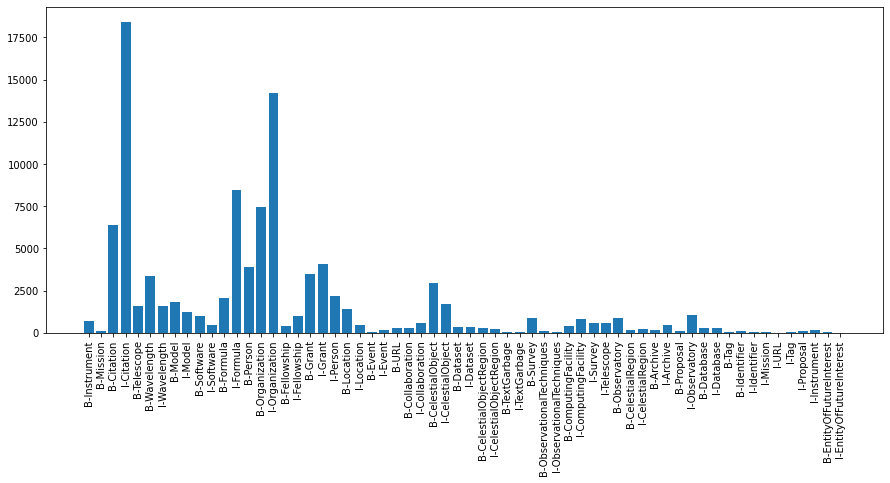

In [ ]:
## Plotting the tags (how frequently they are occuring)
del count_dict['O']
data = count_dict
keys = list(data.keys())
values = list(data.values())
fig,ax=plt.subplots(figsize=(15,6))
plt.bar(range(len(data)), values, tick_label=keys)
plt.xticks(rotation=90)
plt.show()

# **CREATING A SIMPLE RNN MODEL**

In [ ]:
###creating vocabulary to check number of unique words

vocab = []
for i in df_TRAINING.tokens:
  vocab.extend(i)
vocab_main = []
for word in vocab:
  words = word.lower()
  vocab_main.append(words)

In [ ]:
len(np.unique(vocab_main))

45753

In [ ]:
len(vocab)

573132

In [ ]:
# Define a tokenizer with vocabulary size of vocab_main
Tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=len(np.unique(vocab_main)),
        filters= None,
        lower=True,
        char_level=False,
        oov_token=None)

In [ ]:
# Fit the tokenizer on the comments column of the train set
Tokenizer.fit_on_texts(df_TRAINING.tokens)

In [ ]:
#converting word to index and index to word 
word2idx = Tokenizer.word_index
idx2word = Tokenizer.index_word
vocab_size = Tokenizer.num_words

In [ ]:
#creating a tag_list 
tag_list = []
for j in df_TRAINING.ner_tags:
    for i in j:
        if i not in tag_list:
            tag_list.append(i)

In [ ]:
len(tag_list)

63

In [ ]:
# Define a tokenizer with vocabulary size of length of tag_list
#converting word to index and index to word for tags
Tokenizer_2 = tf.keras.preprocessing.text.Tokenizer(num_words=len(tag_list))
Tokenizer_2.fit_on_texts(df_TRAINING.ner_tags)
word2idx_tag = Tokenizer_2.word_index
idx2word_tag = Tokenizer_2.index_word
vocab_size_tag = Tokenizer_2.num_words
#word2idx_tag

In [ ]:
#converting texts to sequences for tokens and ner_tags
token_seq = Tokenizer.texts_to_sequences(df_TRAINING.tokens)
ner_tag_seq = Tokenizer_2.texts_to_sequences(df_TRAINING.ner_tags)

In [ ]:
#Padding the sequences for tokens and ner_tags
token_pad = sequence.pad_sequences(token_seq, maxlen=300, padding='post', truncating='post').reshape((-1,300))
ner_tag_pad = sequence.pad_sequences(ner_tag_seq, maxlen=300, padding='post', truncating='post').reshape((-1,300))

In [ ]:
#making the train_test_split for tokens and ner_tags
X_train, X_test, y_train, y_test = train_test_split(token_pad, ner_tag_pad, test_size=0.2)

In [ ]:
#checking the x_train, y_train, x_test, y_test shapes
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((1402, 300), (1402, 300)), ((351, 300), (351, 300)))

In [ ]:
(X_test.shape, y_test.shape)

((351, 300), (351, 300))

In [ ]:
#Defining a simple rnn model

inputs=Input((300,))
#Adding an embedding layer
embedding_layer=layers.Embedding(input_dim=len(np.unique(vocab_main)) +1,output_dim=300,mask_zero=True)(inputs)
#Adding a simple RNN layer with dropout layer
RNN_Layer1=layers.SimpleRNN(300,return_sequences=True)(embedding_layer)
dropout_1=layers.Dropout(0.1)(RNN_Layer1)
#Adding a simple RNN layer with dropout layer
RNN_Layer2=layers.SimpleRNN(300,return_sequences=True)(dropout_1)
dropout_2=layers.Dropout(0.1)(RNN_Layer2)
#Adding a Dense layer with dropout layer
dense_layer=layers.Dense(300,activation='relu')(dropout_2)
dropout_3=layers.Dropout(0.1)(dense_layer)
#Adding a output Dense layer 
outputs=layers.Dense(300,activation='softmax')(dropout_3)
SimpleRNN_model=Model(inputs,outputs)
SimpleRNN_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 300, 300)          13726200  
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 300, 300)          180300    
                                                                 
 dropout_5 (Dropout)         (None, 300, 300)          0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 300, 300)          180300    
                                                                 
 dropout_6 (Dropout)         (None, 300, 300)          0         
                                                                 
 dense_2 (Dense)             (None, 300, 300)          9030

In [ ]:
#compile the model with optimizer as adam and loss as sparse categorical crossentropy and metrics as accuracy 
SimpleRNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics="accuracy")
# Train the model with appropriate batch size and number of epochs
SimpleRNN_model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=64)

Epoch 1/20
22/22 [==============================] - 58s 2s/step - loss: 1.3548 - accuracy: 0.7412 - val_loss: 0.8608 - val_accuracy: 0.7882
Epoch 2/20
22/22 [==============================] - 54s 2s/step - loss: 0.8474 - accuracy: 0.7997 - val_loss: 0.8322 - val_accuracy: 0.7882
Epoch 3/20
22/22 [==============================] - 54s 2s/step - loss: 0.8319 - accuracy: 0.7985 - val_loss: 0.8256 - val_accuracy: 0.7882
Epoch 4/20
22/22 [==============================] - 54s 2s/step - loss: 0.8065 - accuracy: 0.7996 - val_loss: 0.7752 - val_accuracy: 0.7883
Epoch 5/20
22/22 [==============================] - 54s 2s/step - loss: 0.6883 - accuracy: 0.8082 - val_loss: 0.5978 - val_accuracy: 0.8115
Epoch 6/20
22/22 [==============================] - 56s 3s/step - loss: 0.5194 - accuracy: 0.8308 - val_loss: 0.5185 - val_accuracy: 0.8437
Epoch 7/20
22/22 [==============================] - 59s 3s/step - loss: 0.4435 - accuracy: 0.8544 - val_loss: 0.4864 - val_accuracy: 0.8448
Epoch 8/20
22/22 [==

In [ ]:
# Evaluate the model on the custom test set and report the accuracy
SimpleRNN_accuracy = SimpleRNN_model.evaluate(X_test, y_test)[1]
print(f'The accuracy for the SimpleRNN model is {100*SimpleRNN_accuracy:.2f}%')


11/11 [==============================] - 3s 317ms/step - loss: 0.4648 - accuracy: 0.8943
The accuracy for the SimpleRNN model is 89.43%


In [ ]:
# Predict on the test set
pred = SimpleRNN_model.predict(X_test)
pred = pred.argmax(axis=1)

In [ ]:
#reshaping itbecause it is multidimensional array
pred = pred.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
#checking the shapes of pred and y_test
(pred.shape),(y_test.shape)

((105300, 1), (105300, 1))

In [ ]:
f1_score(y_test,pred,average = 'weighted')

0.0663640048651911

In [ ]:
precision_score(y_test,pred,average = 'weighted')

0.43350931641999363

In [ ]:
recall_score(y_test,pred,average = 'weighted')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.042896486229819564

# **CREATING GRU MODEL**

In [ ]:
#Defining a simple GRU model

inputs=Input((300,))
#Adding an embedding layer
embedding_layer=layers.Embedding(input_dim=len(np.unique(vocab_main)) +1,output_dim=300,mask_zero=True)(inputs)
#Adding a GRU layer with dropout layer
GRU_Layer1=layers.GRU(300,return_sequences=True)(embedding_layer)
dropout_1=layers.Dropout(0.1)(GRU_Layer1)
#Adding a GRU layer with dropout layer
GRU_Layer2=layers.GRU(300,return_sequences=True)(dropout_1)
dropout_2=layers.Dropout(0.1)(GRU_Layer2)
#Adding a Dense layer with dropout layer
dense_layer=layers.Dense(300,activation='relu')(dropout_2)
dropout_3=layers.Dropout(0.1)(dense_layer)
#Adding a output Dense layer
outputs=layers.Dense(300,activation='softmax')(dropout_3)
GRU_model=Model(inputs,outputs)
GRU_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 300, 300)          13726200  
                                                                 
 gru_5 (GRU)                 (None, 300, 300)          541800    
                                                                 
 dropout_12 (Dropout)        (None, 300, 300)          0         
                                                                 
 gru_6 (GRU)                 (None, 300, 300)          541800    
                                                                 
 dropout_13 (Dropout)        (None, 300, 300)          0         
                                                                 
 dense_6 (Dense)             (None, 300, 300)          9030

In [ ]:
#compile the model with optimizer as adam and loss as sparse categorical crossentropy and metrics as accuracy 
GRU_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

In [ ]:
# Train the model with appropriate batch size and number of epochs
#batch_size = 30
num_epochs = 2
history = GRU_model.fit(X_train, y_train, epochs=num_epochs,batch_size = 30)

Epoch 1/2
47/47 [==============================] - 177s 4s/step - loss: 1.3649 - accuracy: 0.7825
Epoch 2/2
47/47 [==============================] - 173s 4s/step - loss: 0.6051 - accuracy: 0.8198


In [ ]:
# Evaluate the model on the custom test set and report the accuracy
GRU_accuracy = GRU_model.evaluate(X_test, y_test)[1]
print(f'The accuracy for the GRU model is {100*GRU_accuracy:.2f}%')


11/11 [==============================] - 12s 787ms/step - loss: 0.5270 - accuracy: 0.8394
The accuracy for the GRU model is 83.94%


In [ ]:
# Predict on the test set
pred = GRU_model.predict(X_test)
pred = pred.argmax(axis=1)

In [ ]:
#reshaping itbecause it is multidimensional array
pred = pred.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
#checking the shapes of pred and y_test
(pred.shape),(y_test.shape)

((105300, 1), (105300, 1))

In [ ]:
f1_score(y_test,pred,average = 'weighted')

0.08380340621218234

In [ ]:
precision_score(y_test,pred,average = 'weighted')

0.2884786285269536

In [ ]:
recall_score(y_test,pred,average = 'weighted')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.08910731244064578

# **CREATING LSTM MODEL**

In [ ]:
#Defining a LSTM model
LSTM_model= Sequential(name="LSTM")
inputs=Input((300,))
#Adding an embedding layer
embedding_layer=layers.Embedding(input_dim=len(np.unique(vocab_main)) +1,output_dim=300,mask_zero=True)(inputs)
#Adding a LSTM layer along with dropout layer
LSTM_Layer1=layers.LSTM(300,return_sequences=True)(embedding_layer)
dropout_1=layers.Dropout(0.1)(LSTM_Layer1)
#Adding a LSTM layer along with dropout layer
LSTM_Layer2=layers.LSTM(300,return_sequences=True)(dropout_1)
dropout_2=layers.Dropout(0.1)(LSTM_Layer2)
#Adding a Dense layer along with dropout layer
dense_layer=layers.Dense(300,activation='relu')(dropout_2)
dropout_3=layers.Dropout(0.1)(dense_layer)
#Adding a output Dense layer
outputs=layers.Dense(300,activation='softmax')(dropout_3)
LSTM_model=Model(inputs,outputs)
LSTM_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 300)]             0         
                                                                 
 embedding_8 (Embedding)     (None, 300, 300)          13726200  
                                                                 
 lstm_2 (LSTM)               (None, 300, 300)          721200    
                                                                 
 dropout_18 (Dropout)        (None, 300, 300)          0         
                                                                 
 lstm_3 (LSTM)               (None, 300, 300)          721200    
                                                                 
 dropout_19 (Dropout)        (None, 300, 300)          0         
                                                                 
 dense_10 (Dense)            (None, 300, 300)          9030

In [ ]:
#compile the model with optimizer as adam and loss as sparse categorical crossentropy and metrics as accuracy 
LSTM_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

In [ ]:
# Train the model with appropriate batch size and number of epochs
num_epochs = 2
history = LSTM_model.fit(X_train, y_train, epochs=num_epochs,batch_size = 30)

Epoch 1/2
47/47 [==============================] - 184s 4s/step - loss: 1.2146 - accuracy: 0.7858
Epoch 2/2
47/47 [==============================] - 169s 4s/step - loss: 0.8240 - accuracy: 0.8005


In [ ]:
# Evaluate the model on the custom test set and report the accuracy
LSTM_accuracy = LSTM_model.evaluate(X_test, y_test)[1]
print(f'The accuracy for the LSTM model is {100*LSTM_accuracy:.2f}%')

11/11 [==============================] - 16s 1s/step - loss: 0.8246 - accuracy: 0.7882
The accuracy for the LSTM model is 78.82%


In [ ]:
# Predict on the test set
pred = LSTM_model.predict(X_test)
pred = pred.argmax(axis=1)

In [ ]:
#reshaping itbecause it is multidimensional array
pred = pred.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
(pred.shape),(y_test.shape)

((105300, 1), (105300, 1))

In [ ]:
f1_score(y_test,pred,average = 'weighted')

0.2585558443144341

In [ ]:
precision_score(y_test,pred,average = 'weighted')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.569721305522749

In [ ]:
recall_score(y_test,pred,average = 'weighted')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.36148148148148146